In [2]:
!pip install torchsummary
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import imageio as iio

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Defining Transformation and Batch Size

In [4]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([32,32],antialias=True)])
batch_size = 32

In [5]:
class MyDataset(Dataset):
    def __init__(self, image_path, transform = trans):
        self.image_path = image_path
        self.images = os.listdir(image_path)
        self.transform = transform

 

    def __len__(self):
        return len(self.images)

 

    def __getitem__(self,idx):
        im = iio.imread(f"{self.image_path}/{self.images[idx]}")
        im = np.array(im)
        im = self.transform(im)
        return im

In [6]:
dataset = MyDataset("/kaggle/input/simpsons-faces/cropped")

train_loader = DataLoader(dataset, batch_size = batch_size)

In [7]:
dataset[0].shape
batch = next(iter(train_loader))

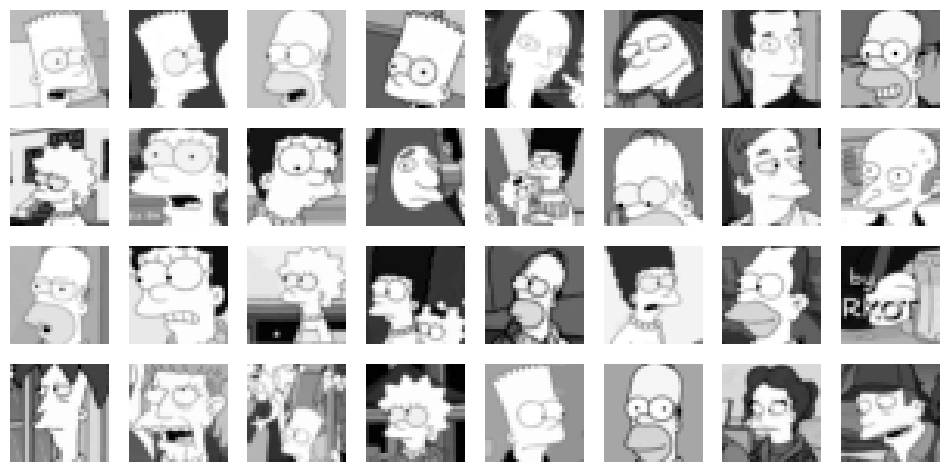

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i in range(32):
    plt.subplot(8, 8, i+1)
    image = batch[i][0] 
    plt.axis('off')
    plt.imshow(image, cmap='gray')  # plotting the batch as greyscale images

plt.show()

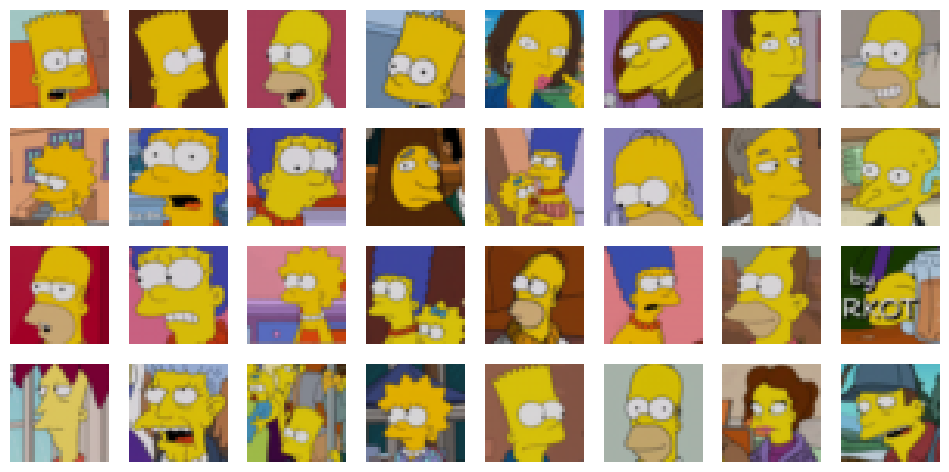

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i in range(32):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    image = batch[i].permute(1, 2, 0)  # plotting the images as 3d
    plt.imshow(image)

plt.show()

Text(0.5, 1.0, 'random sample')

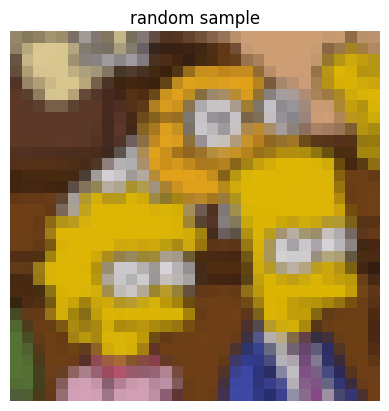

In [17]:
#plotting a sample from the dataset. 
import random
random_index = random.randint(0, len(dataset) - 1)
plt.imshow(dataset[random_index].permute(1,2,0))
plt.axis('off')
plt.title('random sample')

# VAE Class

In [11]:
class VAE(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.nz = nz
        self.econv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.ebn1 = nn.BatchNorm2d(16)
        self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.ebn2 = nn.BatchNorm2d(32)
        self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.ebn3 = nn.BatchNorm2d(64)
        self.elinear1 = nn.Linear(64*8*8, 100)
        self.ebn4 = nn.BatchNorm1d(100)
        self.elinear2 = nn.Linear(100, self.nz)
        self.dlinear1 = nn.Linear(self.nz, 100)
        self.dbn1 = nn.BatchNorm1d(100)
        self.dlinear2 = nn.Linear(100, 64*8*8)
        self.dbn2 = nn.BatchNorm1d(64*8*8)
        self.dtconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dtconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1)
        self.dbn4 = nn.BatchNorm2d(16)
        self.dtconv3 = nn.ConvTranspose2d(16, 3, 3, 1, 1)
        self.plinear1 = nn.Linear(self.nz, self.nz)
        self.plinear2 = nn.Linear(self.nz, self.nz)

    def encoder_head(self, x):
        x = torch.relu(self.econv1(x))
        x = self.ebn1(x)
        x = torch.relu(self.econv2(x))
        x = self.ebn2(x)
        x = torch.relu(self.econv3(x))
        x = self.ebn3(x)
        x = x.view(-1, 64*8*8)
        x = torch.relu(self.elinear1(x))
        x = self.ebn4(x)
        x = torch.sigmoid(self.elinear2(x))
        return x

    def get_params(self, x):
        mu = self.plinear1(x)
        logvar = self.plinear2(x)
        return mu, logvar

    def encoder(self, x):
        x = self.encoder_head(x)
        mu, logvar = self.get_params(x)
        z = torch.exp(0.5 * logvar) * torch.randn_like(logvar) + mu
        return z, mu, logvar

    def decoder(self, x):
        x = torch.relu(self.dlinear1(x))
        x = self.dbn1(x)
        x = torch.relu(self.dlinear2(x))
        x = self.dbn2(x)
        x = x.view(-1, 64, 8, 8)
        x = torch.relu(self.dtconv1(x))
        x = self.dbn3(x)
        x = torch.relu(self.dtconv2(x))
        x = self.dbn4(x)
        x = torch.sigmoid(self.dtconv3(x))
        return x

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x = self.decoder(z)
        return z, x, mu, logvar

# KL_loss = (1/N) * sum(sum(-0.5 * (1 + log(sigma_j) - exp(log(sigma_j)) - mu_j^2)))

In [12]:
def get_loss(x, xhat, mu, logvar):
    m = 1e-4
    recon_loss = F.mse_loss(x,xhat)
    kld_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar)- mu**2), dim=1), dim=0)
    loss = m*kld_loss + (1-m)*recon_loss
    return loss

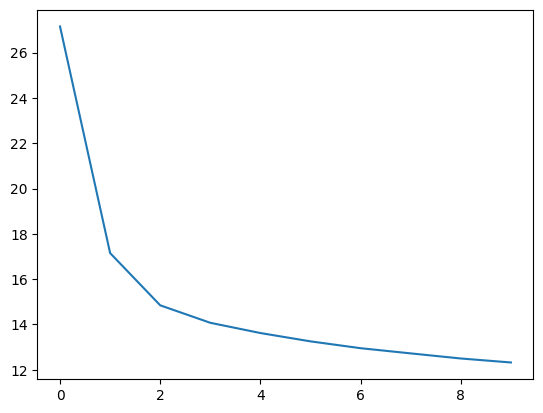

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = batch[0].to(device)

net = VAE(10).to(device)

num_epochs = 10

lr = 1e-4

opt = optim.Adam(net.parameters(), lr=lr)

ls = []

for i in range(num_epochs):
    total_loss = 0

    for batch in train_loader:
        X = batch.to(device)
        Z, Xhat, mu, logvar = net(X)
        loss = get_loss(Xhat, X, mu, logvar)
        total_loss += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()

    ls.append(total_loss)

plt.plot(ls)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision.utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = batch[0].to(device)
net = VAE(10).to(device)
num_epochs = 10
lr = 1e-4
opt = optim.Adam(net.parameters(), lr=lr)
ls = []
img_list = []

fig = plt.figure()

def update(epoch):
    total_loss = 0

    for batch in train_loader:
        X = batch.to(device)
        Z, Xhat, mu, logvar = net(X)
        loss = get_loss(Xhat, X, mu, logvar)
        total_loss += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()

    ls.append(total_loss)

    with torch.no_grad():
        fake = net.decoder(torch.randn(32, nz.shape[1]).to(device)).detach().cpu()
        img_list.append(fake)

    # Clear the plot and display the current generated images
    plt.clf()
    plt.axis("off")
    plt.imshow(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu().numpy().transpose(1, 2, 0))
    plt.title('Generated Images')
    plt.pause(0.01)

ani = animation.FuncAnimation(fig, update, frames=num_epochs, interval=1000)
plt.show()

In [33]:
# Set the fixed noise for visualization
fixed_noise = torch.randn((32, nz.size(0)), device=device)

iters = 0

for epoch in range(num_epochs):
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)

        opt.zero_grad()

        _, recon_batch, mu, logvar = net(batch)
        loss = get_loss(recon_batch, batch, mu, logvar)

        loss.backward()
        opt.step()

        total_loss += loss.item()

        # Check how the VAE is doing by saving reconstructed images
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (batch == len(train_loader)-1)):
            with torch.no_grad():
                fake = net.decoder(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # Print the average loss for the epoch
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    losses.append(avg_loss)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x3 and 10x100)

In [24]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = batch[0].to(device)

net = VAE(10).to(device)

num_epochs = 10

lr = 1e-4

opt = optim.Adam(net.parameters(), lr=lr)
generated_images = []

# Training loop
for i in range(num_epochs):
    total_loss = 0

    for batch in train_loader:
        X = batch.to(device)
        Z, Xhat, mu, logvar = net(X)
        loss = get_loss(Xhat, X, mu, logvar)
        total_loss += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()
    
    with torch.no_grad():
        # Create a random input sample
        z = torch.randn(1, nz, device=device)
        generated_image = net.decoder(z).cpu().squeeze(0)
       
        generated_images.append(generated_image)

# Create the animation
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(img, (1, 2, 0)), animated=True)] for img in generated_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Display the animation
HTML(ani.to_jshtml())

TypeError: randn(): argument 'size' must be tuple of ints, but found element of type Tensor at pos 2

In [14]:
num_samples = 64

z = torch.randn((num_samples, 10)).to(device)

with torch.no_grad():
    Xhat = net.decoder(z)


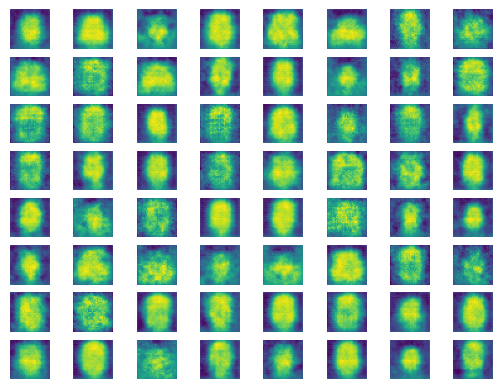

In [16]:
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(Xhat.cpu()[i,0,:,:])


In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())